In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sqlmodel import SQLModel, Session
import re
from ipywidgets import interact, Dropdown


df = pd.read_excel("/home/mikaela/data_science/brott/brott.xlsx", sheet_name="brott")
df.head()

,Lagrum,Brottstyp,Antal brott,"Förändring jämfört med motsvarande period 2023, i antal","Förändring jämfört med motsvarande period 2023, i procent","Antal brott per 100 000 invånare, ackumulerat under 2024"
0,SAMTLIGA BROTT,SAMTLIGA BROTT,1478879,-21760,-1.450049,14015.542698
1,Brott mot brottsbalken,"Brott mot brottsbalken, totalt",1183665,-44564,-3.628314,11217.758416
2,BrB 3-7 kap. Brott mot person,"Brott mot person, totalt",308967,15855,5.409195,2928.123383
3,3 kap. Brott mot liv och hälsa,"Brott mot liv och hälsa, totalt",95509,3006,3.249624,905.152124
4,3 kap. 1-2 § BrB Fullbordat mord och dråp,"Fullbordat mord och dråp, totalt",501,16,3.298969,4.748047


In [2]:
def extrahera_brottslag(lagrum):
    t = str(lagrum)
    m = re.search(r'BrB\s+(.*)', t)
    if m:
        return m.group(1).strip()
    return t.strip()

def klassificera_brottslag(text):
    t = str(text).lower()

    if "fullbordad våldtäkt" in t:
        return "Fullbordad våldtäkt"

    if "misshandel" in t:
        return "Misshandel inkl. grov"

    if "försök till mord" in t or "försök till dråp" in t:
        return "Försök till mord eller dråp"

    if "mord" in t or "dråp" in t:
        return "Fullbordat mord och dråp"

    return extrahera_brottslag(text)


In [3]:
def kön_from_brottstyp(text):
    t = str(text).lower()
    if "flicka" in t:
        return "Flicka"
    if "pojke" in t:
        return "Pojke"
    if "kvinna" in t:
        return "Kvinna"
    if "man" in t and "kvinna" not in t:
        return "Man"
    if "barn" in t:
        return "Barn (ospecificerat kön)"
    return None


def ålder_from_brottstyp(text):
    t = str(text).lower()

    # Misshandel: exakta intervall 
    if "0-6 år" in t:
        if "flicka" in t:
            return "Flicka 0-6 år"
        if "pojke" in t:
            return "Pojke 0-6 år"
        return "Barn 0-6 år"

    if "7-14 år" in t:
        if "flicka" in t:
            return "Flicka 7-14 år"
        if "pojke" in t:
            return "Pojke 7-14 år"
        return "Barn 7-14 år"

    if "15-17 år" in t or "15-17 år" in t:
        if "flicka" in t:
            return "Flicka 15-17 år"
        if "pojke" in t:
            return "Pojke 15-17 år"
        return "Barn 15-17 år"

    # Sexualbrott: under 15 år 
    if "under 15 år" in t:
        if "flicka" in t:
            return "Flicka under 15 år"
        if "pojke" in t:
            return "Pojke under 15 år"
        return "Barn under 15 år"

    # Sexualbrott: 15–17 år 
    if "15-17 år" in t or "15-17 år" in t:
        if "flicka" in t:
            return "Flicka 15-17 år"
        if "pojke" in t:
            return "Pojke 15-17 år"
        return "Barn 15-17 år"

    #  Vuxna 
    if "18 år eller äldre" in t:
        if "kvinna" in t:
            return "Kvinna 18+"
        if "man" in t:
            return "Man 18+"
        return "18+"

    return None


def relation_from_brottstyp(text):
    t = str(text).lower()
    if re.search(r"\bobekant\b|\bobekanta\b", t):
        return "Obekant"
    if "bekant" in t or "närstående" in t or "relation" in t:
        return "Bekant"
    return None


def miljö_from_brottstyp(text):
    t = str(text).lower()
    if "inomhus" in t:
        return "Inomhus"
    if "utomhus" in t:
        return "Utomhus"
    return None


In [4]:
df["Brottslag"] = df["Lagrum"].apply(klassificera_brottslag)
df["Kön"] = df["Brottstyp"].apply(kön_from_brottstyp)
df["Ålder"] = df["Brottstyp"].apply(ålder_from_brottstyp)
df["Relation"] = df["Brottstyp"].apply(relation_from_brottstyp)
df["Miljö"] = df["Brottstyp"].apply(miljö_from_brottstyp)

brottstyper = [
    "Misshandel inkl. grov",
    "Fullbordad våldtäkt",
    "Försök till mord eller dråp",
    "Fullbordat mord och dråp"
]

df = df[df["Brottslag"].isin(brottstyper)]
df.head()


,Lagrum,Brottstyp,Antal brott,"Förändring jämfört med motsvarande period 2023, i antal","Förändring jämfört med motsvarande period 2023, i procent","Antal brott per 100 000 invånare, ackumulerat under 2024",Brottslag,Kön,Ålder,Relation,Miljö
4,3 kap. 1-2 § BrB Fullbordat mord och dråp,"Fullbordat mord och dråp, totalt",501,16,3.298969,4.748047,Fullbordat mord och dråp,None,None,None,None
5,3 kap. 1-2 § BrB Fullbordat mord och dråp,Mot kvinna/flicka,171,-10,-5.524862,1.620591,Fullbordat mord och dråp,Flicka,None,None,None
6,3 kap. 1-2 § BrB Fullbordat mord och dråp,"Mot kvinna/flicka, med användning av skjutvapen",12,-6,-33.333333,0.113726,Fullbordat mord och dråp,Flicka,None,None,None
7,3 kap. 1-2 § BrB Fullbordat mord och dråp,"Mot kvinna/flicka, utan användning av skjutvapen",159,-4,-2.453988,1.506865,Fullbordat mord och dråp,Flicka,None,None,None
8,3 kap. 1-2 § BrB Fullbordat mord och dråp,Mot man/pojke,330,26,8.552632,3.127456,Fullbordat mord och dråp,Pojke,None,None,None


In [5]:
def analysera_brott(df, brottslag):
    d = df[df["Brottslag"] == brottslag].copy()

    if "misshandel" in brottslag.lower():
        d = d[~d["Brottstyp"].str.contains("totalt|total", case=False, na=False)]

    d["Grupp"] = d["Kön"].fillna("Okänt kön") + ", " + d["Ålder"].fillna("Okänd ålder")

    rel = (
        d.groupby(["Grupp", "Relation"], as_index=False)["Antal brott"]
         .sum()
    )

    mil = (
        d.groupby(["Grupp", "Miljö"], as_index=False)["Antal brott"]
         .sum()
    )

    return rel, mil


In [6]:
def plot_relationer(relation_df, brottslag):
    if relation_df.empty:
        print("Inga relationsdata för detta brott.")
        return
    plt.figure(figsize=(10, 5))
    sns.barplot(data=relation_df, x="Grupp", y="Antal brott", hue="Relation")
    plt.xticks(rotation=45, ha="right")
    plt.title(f"Relationer - {brottslag}")
    plt.tight_layout()
    plt.show()


def plot_miljö(miljö_df, brottslag):
    if miljö_df.empty:
        print("Inga miljödata för detta brott.")
        return
    plt.figure(figsize=(10, 5))
    sns.barplot(data=miljö_df, x="Grupp", y="Antal brott", hue="Miljö")
    plt.xticks(rotation=45, ha="right")
    plt.title(f"Miljö - {brottslag}")
    plt.tight_layout()
    plt.show()


In [7]:
def visa_analys(brottslag):
    rel_df, mil_df = analysera_brott(df, brottslag)

    print(f"ANALYS FÖR: {brottslag}")
    display(rel_df)
    plot_relationer(rel_df, brottslag)

    display(mil_df)
    plot_miljö(mil_df, brottslag)

interact(
    visa_analys,
    brottslag=Dropdown(options=brottstyper, description="Välj brott:")
)


interactive(children=(Dropdown(description='Välj brott:', options=('Misshandel inkl. grov', 'Fullbordad våldtä…

<function __main__.visa_analys(brottslag)>

In [8]:
def relation_och_miljo_per_alder(df, brottslag):
    d = df[df["Brottslag"] == brottslag].copy()

    # Ta bort rader utan ålder
    d = d[~d["Ålder"].isna()]

    # Relation per ålder
    rel = (
        d.groupby(["Ålder", "Relation"], as_index=False)["Antal brott"]
         .sum()
    )

    # Lägg till procent inom ålder 
    rel["Andel inom ålder (%)"] = (
        rel["Antal brott"] /
        rel.groupby("Ålder")["Antal brott"].transform("sum") * 100
    ).round(1)

    # Miljö per ålder
    mil = (
        d.groupby(["Ålder", "Miljö"], as_index=False)["Antal brott"]
         .sum()
    )

    mil["Andel inom ålder (%)"] = (
        mil["Antal brott"] /
        mil.groupby("Ålder")["Antal brott"].transform("sum") * 100
    ).round(1)

    return rel, mil



In [9]:
brottslag = "Misshandel inkl. grov"

rel_tabell, mil_tabell = relation_och_miljo_per_alder(df, brottslag)

print("RELATION PER ÅLDER")
display(rel_tabell)

print("MILJÖ PER ÅLDER")
display(mil_tabell)


RELATION PER ÅLDER


,Ålder,Relation,Antal brott,Andel inom ålder (%)
0,Flicka 0-6 år,Bekant,3128,95.8
1,Flicka 0-6 år,Obekant,138,4.2
2,Flicka 15-17 år,Bekant,4698,82.1
3,Flicka 15-17 år,Obekant,1024,17.9
4,Flicka 7-14 år,Bekant,10284,89.8
5,Flicka 7-14 år,Obekant,1174,10.2
6,Kvinna 18+,Bekant,50966,80.8
7,Kvinna 18+,Obekant,12112,19.2
8,Man 18+,Bekant,27524,44.3
9,Man 18+,Obekant,34608,55.7


MILJÖ PER ÅLDER


,Ålder,Miljö,Antal brott,Andel inom ålder (%)
0,Flicka 0-6 år,Inomhus,1500,91.9
1,Flicka 0-6 år,Utomhus,133,8.1
2,Flicka 15-17 år,Inomhus,1889,66.0
3,Flicka 15-17 år,Utomhus,972,34.0
4,Flicka 7-14 år,Inomhus,4264,74.4
5,Flicka 7-14 år,Utomhus,1465,25.6
6,Kvinna 18+,Inomhus,24561,77.9
7,Kvinna 18+,Utomhus,6978,22.1
8,Man 18+,Inomhus,14847,47.8
9,Man 18+,Utomhus,16219,52.2


In [10]:
def plot_relation_och_miljo_per_alder(df, brottslag):
    rel_tabell, mil_tabell = relation_och_miljo_per_alder(df, brottslag)

    # Relation
    if not rel_tabell.empty:
        plt.figure(figsize=(10, 5))
        sns.barplot(data=rel_tabell, x="Ålder", y="Andel inom ålder (%)", hue="Relation")
        plt.title(f"- {brottslag}")
        plt.xticks(rotation=0, ha="right")
        plt.tight_layout()
        plt.show()
    else:
        print("Inga relationsdata för detta brott.")

    # Miljö
    if not mil_tabell.empty:
        plt.figure(figsize=(10, 5))
        sns.barplot(data=mil_tabell, x="Ålder", y="Andel inom ålder (%)", hue="Miljö")
        plt.title(f"Miljö per åldersgrupp - {brottslag}")
        plt.xticks(rotation=0, ha="right")
        plt.tight_layout()
        plt.show()
    else:
        print("Inga miljödata för detta brott.")


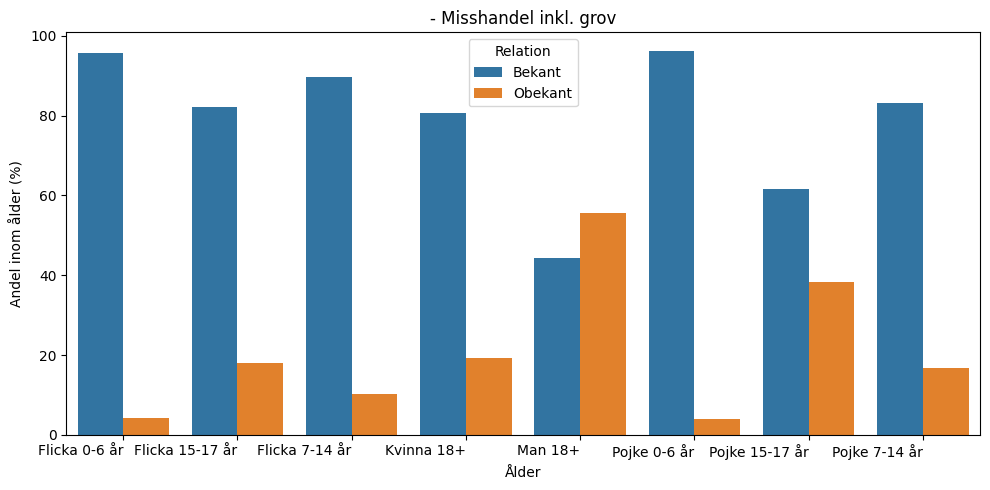

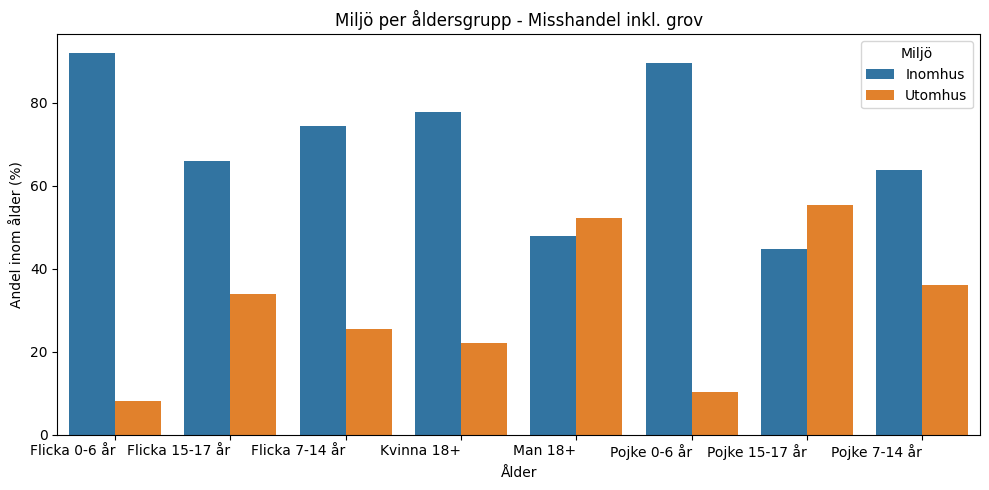

In [11]:
plot_relation_och_miljo_per_alder(df, "Misshandel inkl. grov")


In [12]:
relation_och_miljo_per_alder(df, brottslag)


(              Ålder Relation  Antal brott  Andel inom ålder (%)
 0     Flicka 0-6 år   Bekant         3128                  95.8
 1     Flicka 0-6 år  Obekant          138                   4.2
 2   Flicka 15-17 år   Bekant         4698                  82.1
 3   Flicka 15-17 år  Obekant         1024                  17.9
 4    Flicka 7-14 år   Bekant        10284                  89.8
 5    Flicka 7-14 år  Obekant         1174                  10.2
 6        Kvinna 18+   Bekant        50966                  80.8
 7        Kvinna 18+  Obekant        12112                  19.2
 8           Man 18+   Bekant        27524                  44.3
 9           Man 18+  Obekant        34608                  55.7
 10     Pojke 0-6 år   Bekant         4366                  96.1
 11     Pojke 0-6 år  Obekant          178                   3.9
 12   Pojke 15-17 år   Bekant         5274                  61.6
 13   Pojke 15-17 år  Obekant         3288                  38.4
 14    Pojke 7-14 år   Be

In [13]:
def plot_relation_pie(df, brottslag):
    rel_tabell, _ = relation_och_miljo_per_alder(df, brottslag)

    if rel_tabell.empty:
        print("Inga relationsdata för detta brottslag.")
        return

    åldrar = rel_tabell["Ålder"].unique()

    for ålder in åldrar:
        subset = rel_tabell[rel_tabell["Ålder"] == ålder]

        plt.figure(figsize=(6, 6))
        plt.pie(
            subset["Antal brott"],
            labels=subset["Relation"],
            autopct="%1.1f%%",
            startangle=90
        )
        plt.title(f"Relation - {brottslag} - {ålder}")
        plt.show()


In [14]:
def plot_miljo_pie(df, brottslag):
    _, mil_tabell = relation_och_miljo_per_alder(df, brottslag)

    if mil_tabell.empty:
        print("Inga miljödata för detta brottslag.")
        return

    åldrar = mil_tabell["Ålder"].unique()

    for ålder in åldrar:
        subset = mil_tabell[mil_tabell["Ålder"] == ålder]

        plt.figure(figsize=(6, 6))
        plt.pie(
            subset["Antal brott"],
            labels=subset["Miljö"],
            autopct="%1.1f%%",
            startangle=90
        )
        plt.title(f"Miljö - {brottslag} - {ålder}")
        plt.show()


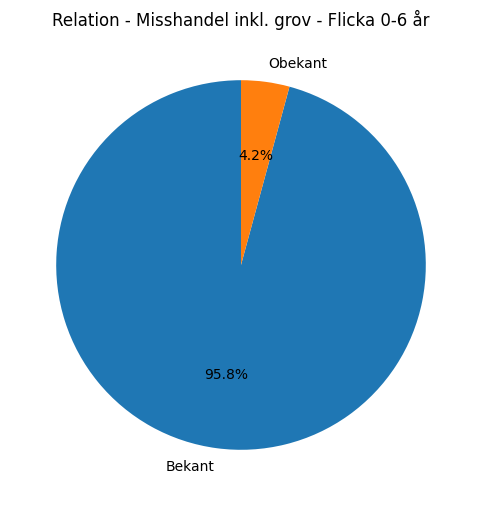

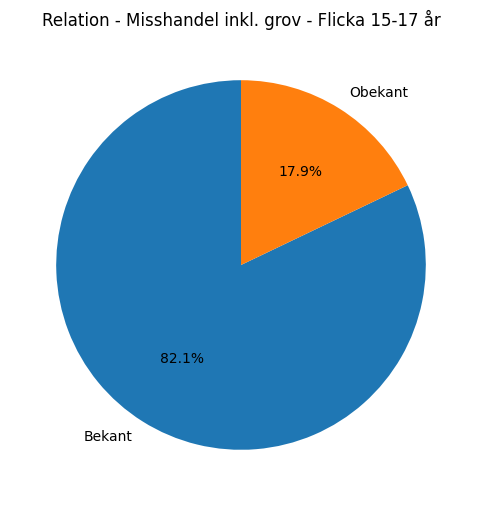

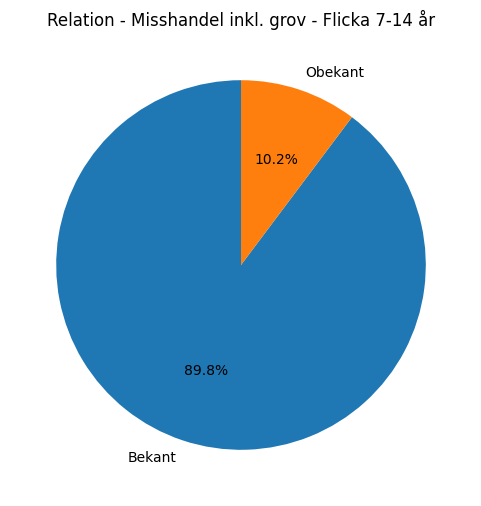

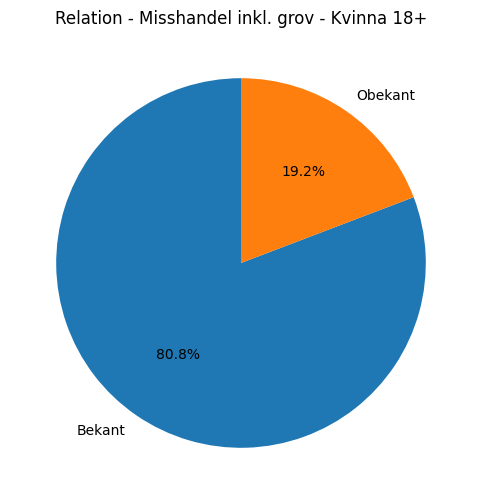

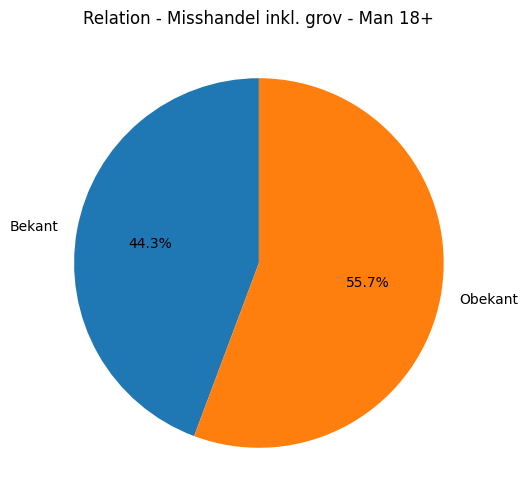

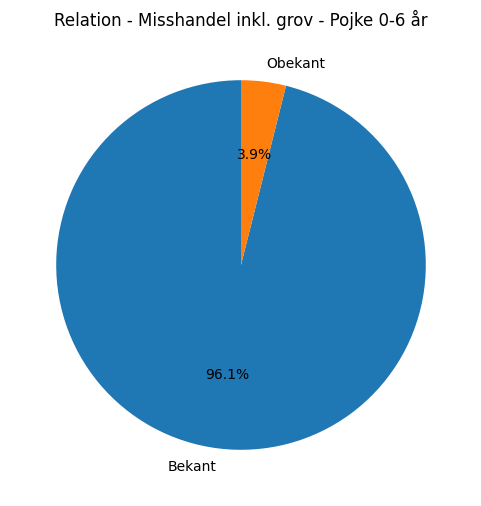

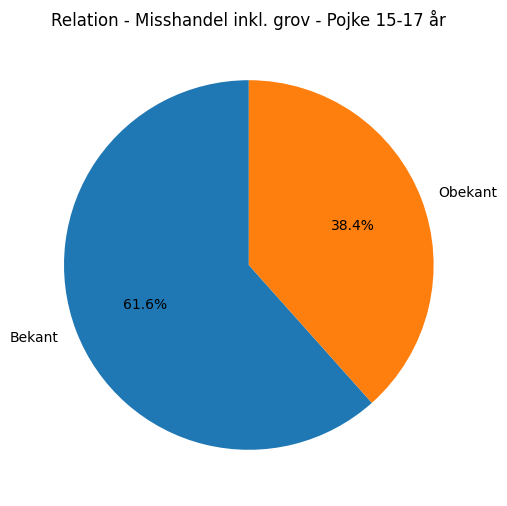

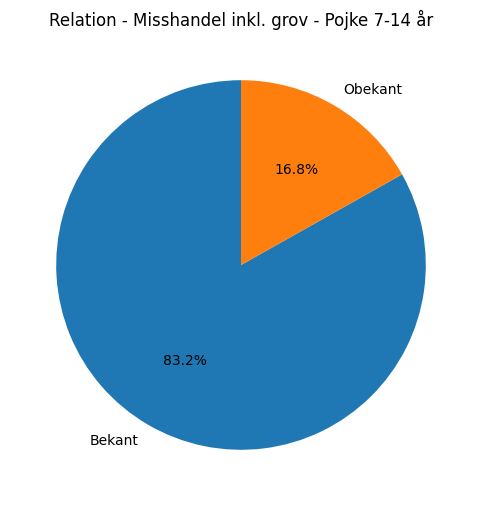

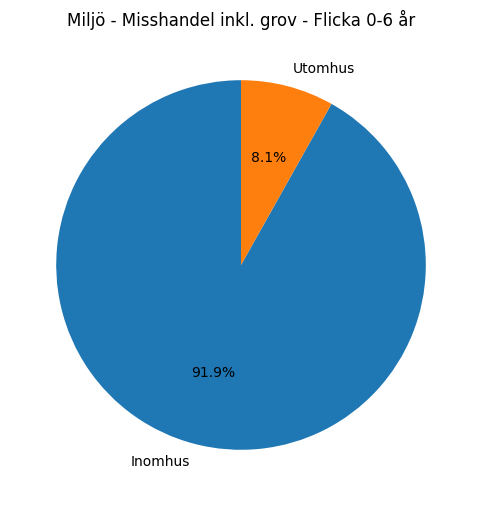

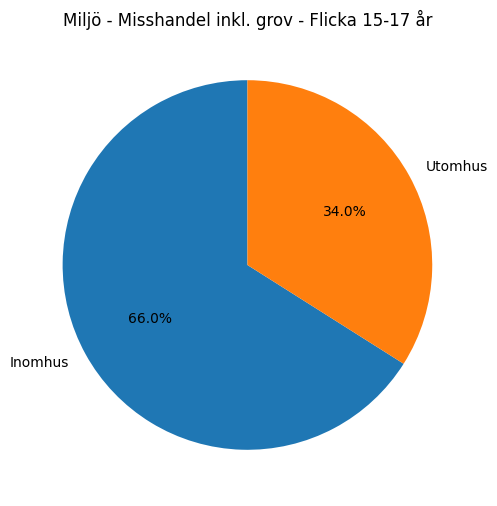

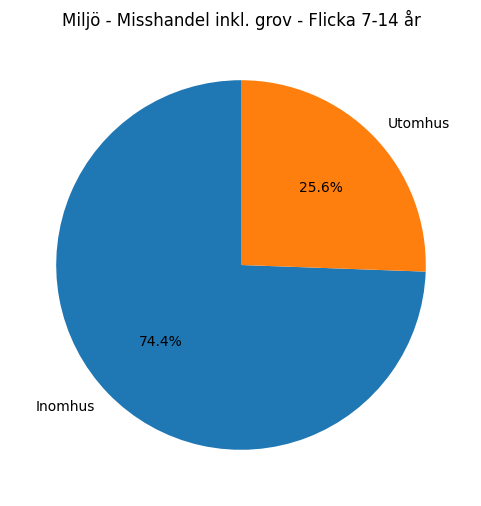

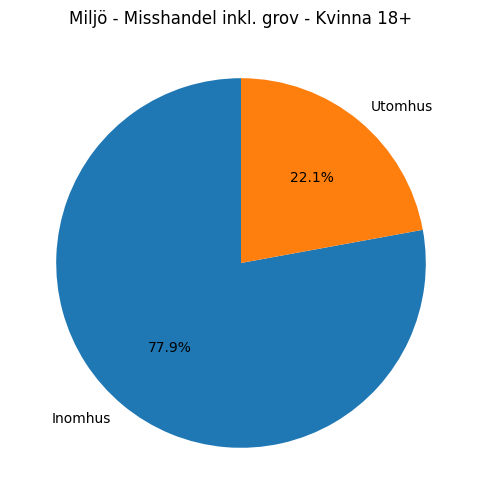

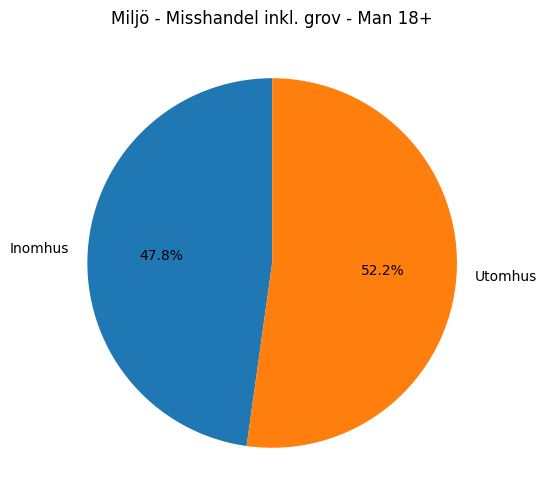

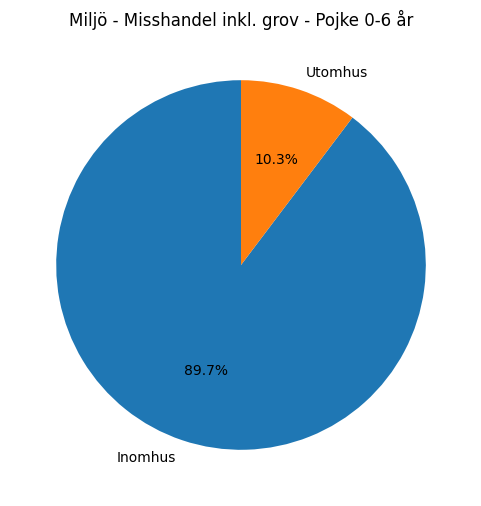

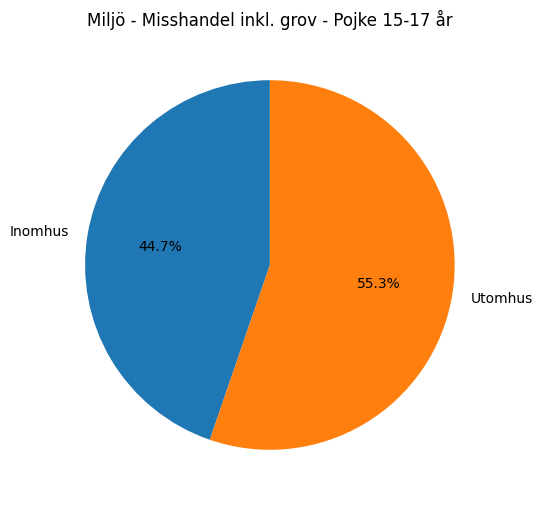

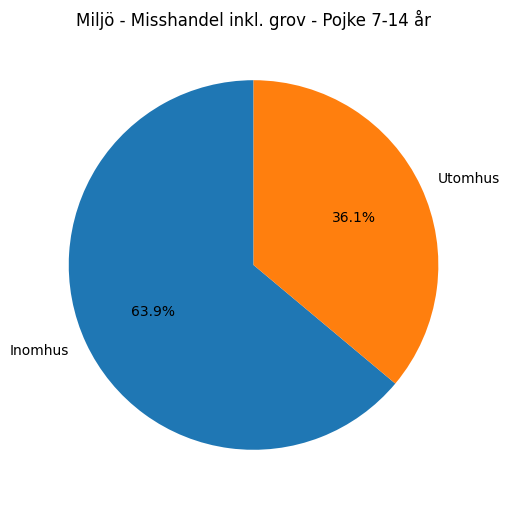

In [15]:
plot_relation_pie(df, "Misshandel inkl. grov")
plot_miljo_pie(df, "Misshandel inkl. grov")


In [16]:
def plot_kon_pie(df, brottslag):
    d = df[df["Brottslag"] == brottslag].copy()

    # Ta bort totalrader
    d = d[~d["Brottstyp"].str.contains("totalt", case=False, na=False)]

    # Ta bort rader utan kön
    d = d[d["Kön"].isin(["Flicka", "Pojke", "Kvinna", "Man"])]

    # Skapa två grupper: kvinnligt kön och manligt kön
    d["Könsgrupp"] = d["Kön"].replace({
        "Flicka": "Kvinnligt kön",
        "Kvinna": "Kvinnligt kön",
        "Pojke": "Manligt kön",
        "Man": "Manligt kön"
    })

    # Summera antal brott per könsgrupp
    kön_sum = d.groupby("Könsgrupp", as_index=False)["Antal brott"].sum()

    # Rita cirkeldiagram
    plt.figure(figsize=(6, 6))
    plt.pie(
        kön_sum["Antal brott"],
        labels=kön_sum["Könsgrupp"],
        autopct="%1.1f%%",
        startangle=90
    )
    plt.title(f"Könsfördelning - {brottslag}")
    plt.show()




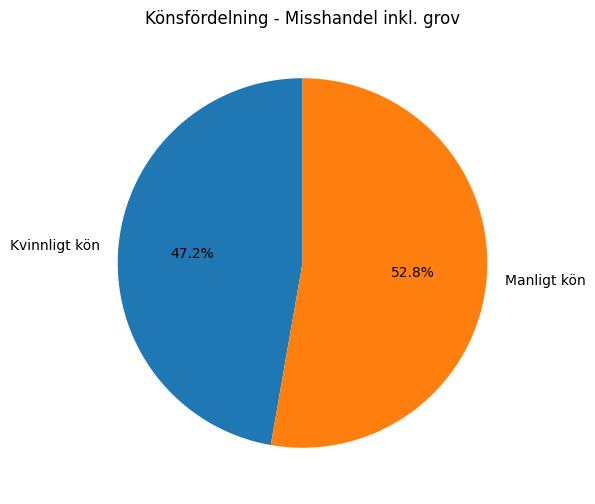

In [17]:
plot_kon_pie(df, "Misshandel inkl. grov")


In [18]:
def plot_kon_miljo(df, brottslag):
    d = df[df["Brottslag"] == brottslag].copy()

    # Ta bort totalrader
    d = d[~d["Brottstyp"].str.contains("totalt", case=False, na=False)]

    # Ta bort rader utan miljö
    d = d[d["Miljö"].isin(["Inomhus", "Utomhus"])]

    # Ta bort rader utan kön
    d = d[d["Kön"].isin(["Flicka", "Pojke", "Kvinna", "Man"])]

    # Skapa två grupper: kvinnligt kön och manligt kön
    d["Könsgrupp"] = d["Kön"].replace({
        "Flicka": "Kvinnligt kön",
        "Kvinna": "Kvinnligt kön",
        "Pojke": "Manligt kön",
        "Man": "Manligt kön"
    })

    # Grupp: kön × miljö
    tabell = (
        d.groupby(["Könsgrupp", "Miljö"], as_index=False)["Antal brott"]
         .sum()
    )

    # Rita diagram
    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=tabell,
        x="Könsgrupp",
        y="Antal brott",
        hue="Miljö"
    )
    plt.title(f"Kön × Miljö - {brottslag}")
    plt.xlabel("Kön")
    plt.ylabel("Antal brott")
    plt.tight_layout()
    plt.show()
×

SyntaxError: invalid character '×' (U+00D7) (3472296681.py, line 40)

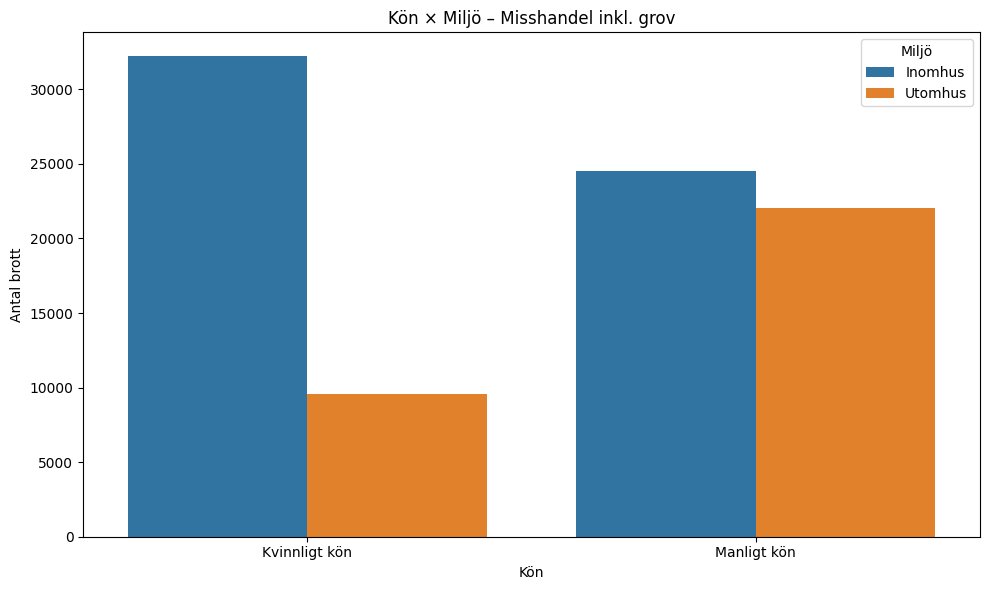

In [ ]:
plot_kon_miljo(df, "Misshandel inkl. grov")


In [ ]:
def plot_kon_miljo_alder(df, brottslag):
    d = df[df["Brottslag"] == brottslag].copy()

    # Ta bort totalrader
    d = d[~d["Brottstyp"].str.contains("totalt", case=False, na=False)]

    # Ta bort rader utan miljö
    d = d[d["Miljö"].isin(["Inomhus", "Utomhus"])]

    # Ta bort rader utan kön
    d = d[d["Kön"].isin(["Flicka", "Pojke", "Kvinna", "Man"])]

    # Skapa två grupper: kvinnligt kön och manligt kön
    d["Könsgrupp"] = d["Kön"].replace({
        "Flicka": "Kvinnligt kön",
        "Kvinna": "Kvinnligt kön",
        "Pojke": "Manligt kön",
        "Man": "Manligt kön"
    })

    # Grupp: kön × miljö × ålder
    tabell = (
        d.groupby(["Ålder", "Könsgrupp", "Miljö"], as_index=False)["Antal brott"]
         .sum()
    )

    plt.figure(figsize=(14, 7))
    sns.barplot(
        data=tabell,
        x="Ålder",
        y="Antal brott",
        hue="Miljö",
        palette="Set2",
        dodge=True
    )

    # Dela upp staplarna per kön
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.title(f"Kön × Miljö × Ålder - {brottslag}")
    plt.show()

    return tabell


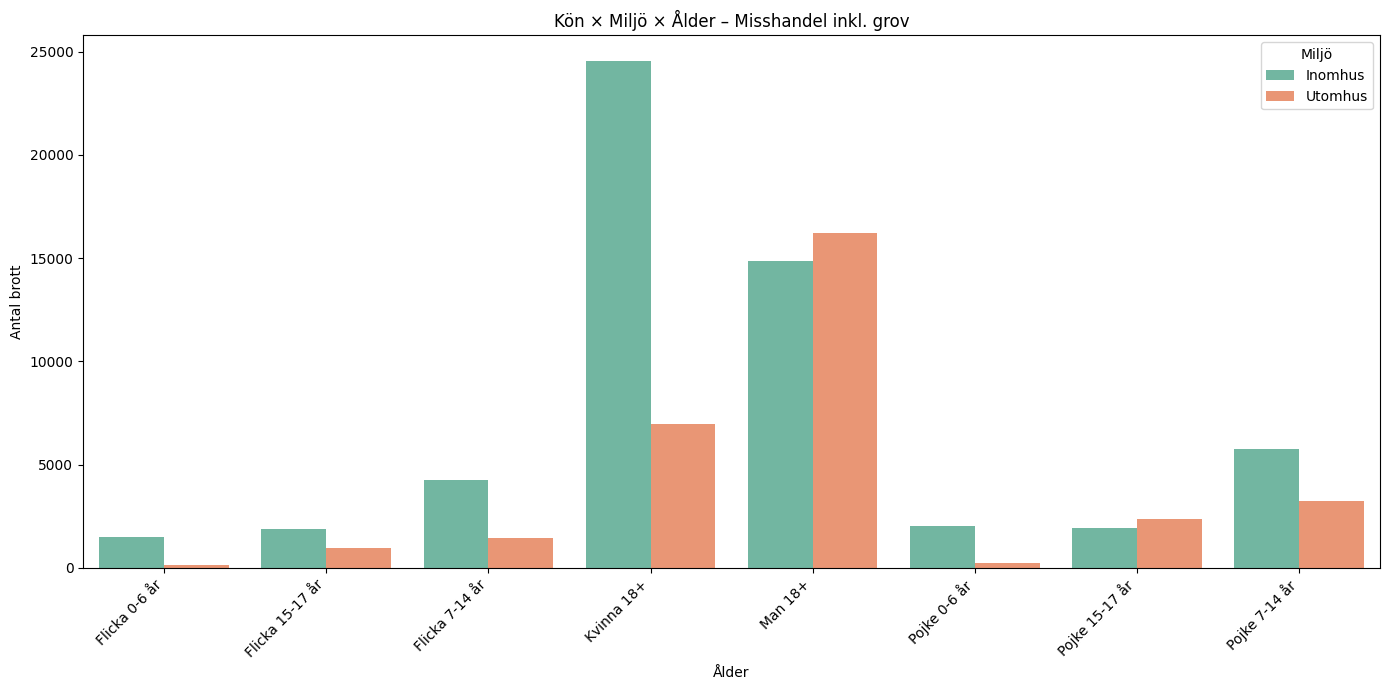

,Ålder,Könsgrupp,Miljö,Antal brott
0,Flicka 0-6 år,Kvinnligt kön,Inomhus,1500
1,Flicka 0-6 år,Kvinnligt kön,Utomhus,133
2,Flicka 15-17 år,Kvinnligt kön,Inomhus,1889
3,Flicka 15-17 år,Kvinnligt kön,Utomhus,972
4,Flicka 7-14 år,Kvinnligt kön,Inomhus,4264
5,Flicka 7-14 år,Kvinnligt kön,Utomhus,1465
6,Kvinna 18+,Kvinnligt kön,Inomhus,24561
7,Kvinna 18+,Kvinnligt kön,Utomhus,6978
8,Man 18+,Manligt kön,Inomhus,14847
9,Man 18+,Manligt kön,Utomhus,16219


In [ ]:
plot_kon_miljo_alder(df, "Misshandel inkl. grov")


In [ ]:
def plot_flickor_pojkar_relation_miljo(df):
    d = df[df["Brottslag"] == "Misshandel inkl. grov"].copy()

    # Ta bort totalrader
    d = d[~d["Brottstyp"].str.contains("totalt", case=False, na=False)]

    # Endast flickor och pojkar
    d = d[d["Kön"].isin(["Flicka", "Pojke"])]

    fig, axes = plt.subplots(2, 2, figsize=(10, 10))

    könsgrupper = ["Flicka", "Pojke"]
    miljöer = ["Inomhus", "Utomhus"]

    for i, kön in enumerate(könsgrupper):
        subset = d[d["Kön"] == kön]

        # Miljö
        milj = subset[subset["Miljö"].isin(miljöer)]
        milj = milj.groupby("Miljö")["Antal brott"].sum()

        axes[i, 0].pie(
            milj.values,
            labels=milj.index,
            autopct="%1.1f%%",
            startangle=90
        )
        axes[i, 0].set_title(f"{kön} - Miljö")

        # Relation
        rel = subset.groupby("Relation")["Antal brott"].sum()

        axes[i, 1].pie(
            rel.values,
            labels=rel.index,
            autopct="%1.1f%%",
            startangle=90
        )
        axes[i, 1].set_title(f"{kön} - Relation")

    plt.suptitle("Flickor vs Pojkar - Miljö och Relation (Misshandel inkl. grov)", fontsize=14)
    plt.tight_layout()
    plt.show()


In [ ]:
def plot_kvinnor_man_relation_miljo(df):
    d = df[df["Brottslag"] == "Misshandel inkl. grov"].copy()

    # Ta bort totalrader
    d = d[~d["Brottstyp"].str.contains("totalt", case=False, na=False)]

    # Endast kvinnor och män
    d = d[d["Kön"].isin(["Kvinna", "Man"])]

    fig, axes = plt.subplots(2, 2, figsize=(10, 10))

    könsgrupper = ["Kvinna", "Man"]
    miljöer = ["Inomhus", "Utomhus"]

    for i, kön in enumerate(könsgrupper):
        subset = d[d["Kön"] == kön]

        # Miljö
        milj = subset[subset["Miljö"].isin(miljöer)]
        milj = milj.groupby("Miljö")["Antal brott"].sum()

        axes[i, 0].pie(
            milj.values,
            labels=milj.index,
            autopct="%1.1f%%",
            startangle=90
        )
        axes[i, 0].set_title(f"{kön} - Miljö")

        # Relation
        rel = subset.groupby("Relation")["Antal brott"].sum()

        axes[i, 1].pie(
            rel.values,
            labels=rel.index,
            autopct="%1.1f%%",
            startangle=90
        )
        axes[i, 1].set_title(f"{kön} - Relation")

    plt.suptitle("Kvinnor vs Män - Miljö och Relation (Misshandel inkl. grov)", fontsize=14)
    plt.tight_layout()
    plt.show()


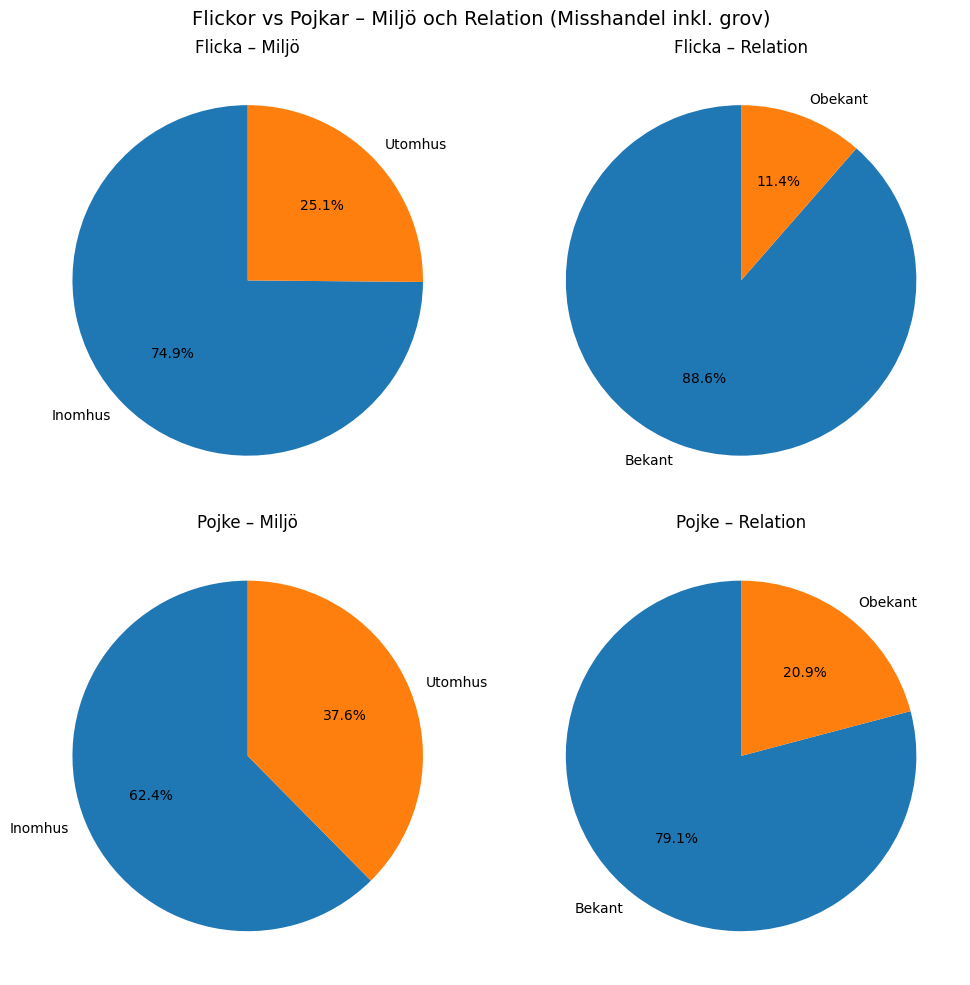

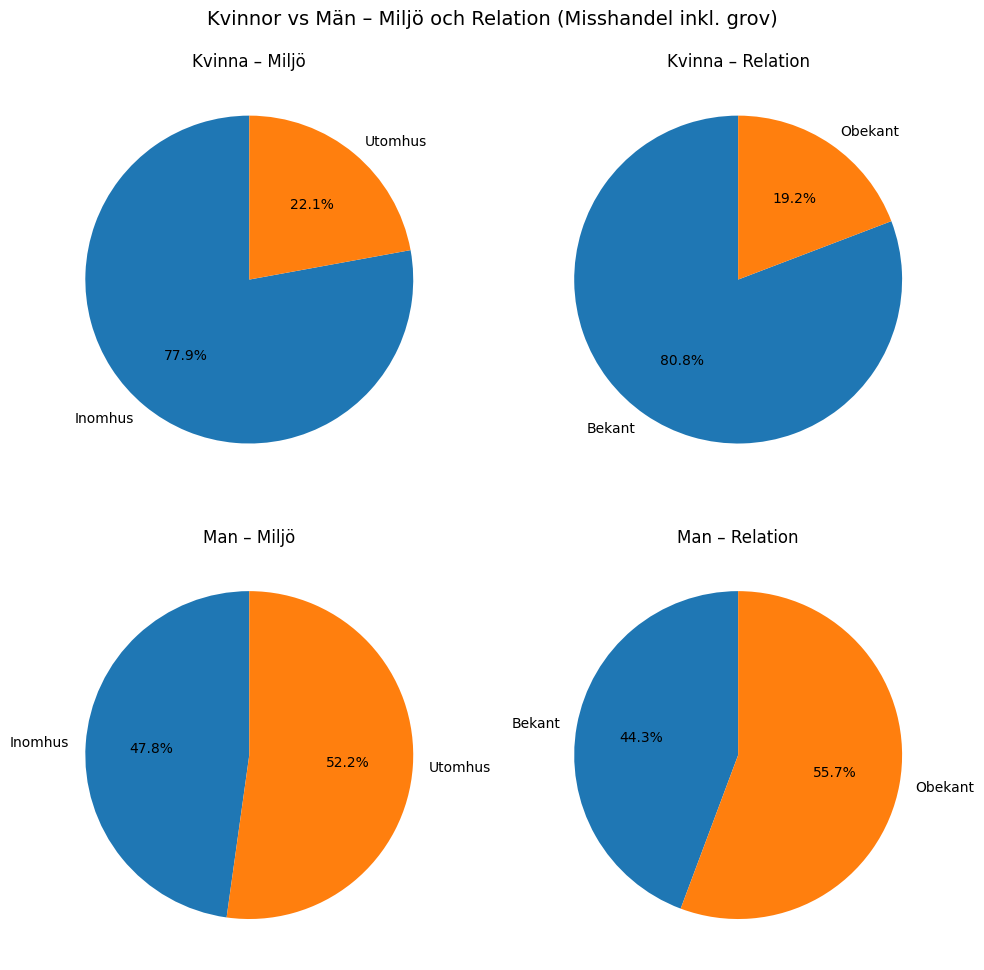

In [ ]:
plot_flickor_pojkar_relation_miljo(df)
plot_kvinnor_man_relation_miljo(df)
